In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, subprocess
from natsort import natsorted
import pickle

REPO_PATH = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
plt.style.use(f'{REPO_PATH}/misc/edwin.mplstyle')

In [2]:
from retrieveVariables import retrieveVariables

In [3]:
fields = ["DOC","NH4","NO3","O2","phi"]
isHot  = False

if (isHot):
    ## With hot-start
    RANS = retrieveVariables("/home/edsaa/nuModel/tempBioreactions/2.0NonZeroRANS/2.0NonZeroInitCondition/",fields)
    LES  = retrieveVariables("/home/edsaa/nuModel/tempBioreactions/2.1LES/2.1NonZeroLESRun/",fields)
else:
    ## Without hot-start
    RANS = retrieveVariables("/home/edsaa/nuModel/tempBioreactions/2.3ZeroStartRANS/2.3ZeroRANS",fields)
    LES  = retrieveVariables("/home/edsaa/nuModel/tempBioreactions/2.2ZeroLES/2.2ZeroLES",fields)

In [4]:
## Elliot-Brooks phi
hydCond = 1.3E-3
head_m  = 2.39E-4
bed_wavelenght = 0.15
depth_bed = 0.20
channel_width = 0.29
porosity = 0.33
Axy = bed_wavelenght*channel_width

qBar = (2*hydCond * head_m / bed_wavelenght) * np.tanh(2*np.pi*depth_bed/bed_wavelenght)
qBar *= Axy
print("qBar = {:.2E} m3/s".format(qBar))

qBar = 1.80E-07 m3/s


In [5]:
## Negative phi is flux INTO the bed (influx)

for df in [RANS,LES]:
    df['Time (d)'] = df['Time (s)']/86400
    df['sumPhiIn (m3/s)']  = [ np.sum(np.minimum(p,0)) for p in df['phi'] ]
    df['sumPhiOut (m3/s)'] = [ np.sum(np.maximum(p,0)) for p in df['phi'] ]
    df['sumPhiNet (m3/s)'] = [ np.sum(p) for p in df['phi'] ]
    
    for field in fields: 
        df[f'massIn {field} (kg/s/m2)']  = [ np.sum(np.multiply(np.minimum(p,0),c))/Axy for p,c in zip(df['phi'],df[field]) ]
        df[f'massOut {field} (kg/s/m2)'] = [ np.sum(np.multiply(np.maximum(p,0),c))/Axy for p,c in zip(df['phi'],df[field]) ]
        df[f'massNet {field} (kg/s/m2)'] = [ np.sum(np.multiply(p,c))/Axy for p,c in zip(df['phi'],df[field]) ]

In [6]:
RANS[f'sumPhiOut (m3/s)'].iloc[:len(LES)]

0      1.141470e-08
1      1.141427e-08
2      1.141376e-08
3      1.141321e-08
4      1.141247e-08
           ...     
312    1.975570e-09
313    1.975880e-09
314    1.976243e-09
315    1.976659e-09
316    1.977126e-09
Name: sumPhiOut (m3/s), Length: 317, dtype: float64

In [7]:
LES[f'sumPhiOut (m3/s)']

0      1.908892e-08
1      3.454603e-08
2      2.938273e-08
3      3.899085e-08
4      1.084466e-08
           ...     
312    5.961607e-10
313    1.332040e-09
314    1.229710e-09
315    7.189636e-10
316    1.826219e-09
Name: sumPhiOut (m3/s), Length: 317, dtype: float64

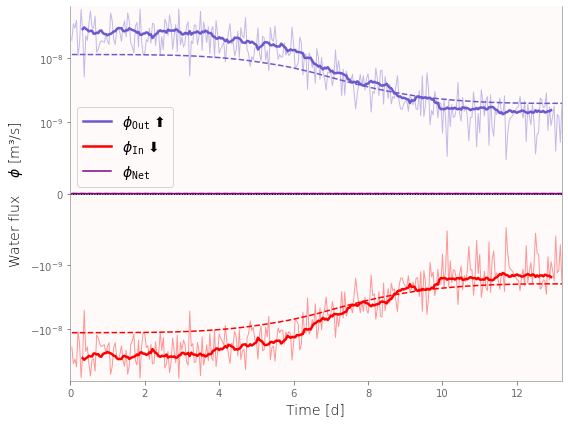

In [8]:
fig,ax = plt.subplots(sharex=True,figsize=[8,6])

df = RANS

ax.plot(df['Time (d)'],df[f'sumPhiOut (m3/s)'],
    c='slateblue',alpha=1.0,lw=1.5,ls='dashed')
ax.plot(df['Time (d)'],df[f'sumPhiIn (m3/s)'],
    c='red',alpha=1.0,lw=1.5,ls='dashed')
ax.plot(df['Time (d)'],df[f'sumPhiNet (m3/s)'],
    c='purple',alpha=1,lw=1.5,ls='dashed')

df = LES
ax.plot(df['Time (d)'],df[f'sumPhiOut (m3/s)'],
    c='slateblue',alpha=0.4,lw=1)
ax.plot(df['Time (d)'],df[f'sumPhiIn (m3/s)'],
    c='red',alpha=0.4,lw=1)

LES['Rolling_sumPhiOut'] = LES[f'sumPhiOut (m3/s)'].rolling(15,center=True).mean()
ax.plot(LES['Time (d)'],LES[f'Rolling_sumPhiOut'], 
        c='slateblue',alpha=1,lw=2.5,label=r'$\phi_\mathtt{Out}$ ⬆️')

LES['Rolling_sumPhiIn'] = LES[f'sumPhiIn (m3/s)'].rolling(15,center=True).mean()
ax.plot(LES['Time (d)'],LES[f'Rolling_sumPhiIn'], 
        c='red',alpha=1,lw=2.5,label=r'$\phi_\mathtt{In}$ ⬇️')

ax.plot(df['Time (d)'],df[f'sumPhiNet (m3/s)'],
        c='purple',alpha=1,lw=1.5,label=r'$\phi_\mathtt{Net}$')

#ax.fill_between(LES['Time (d)'],RANS[f'sumPhiOut (m3/s)'].iloc[:len(LES)],LES[f'sumPhiOut (m3/s)'])



ax.axhline(y=0,ls=':',lw=1,c='k')
ax.legend(loc='lower left',bbox_to_anchor=(0.0,0.5))

ax.set(xlim=[0,13.2])
ax.set_yscale('symlog', linthresh=1.0E-9)

ax.set_xlabel("Time [d]")
ax.set_ylabel(r"Water flux    $\phi$ [m³/s]")

fig.tight_layout()

# Save plot file
fileForSVG = f"RetrieveFluxes/{isHot=}_WaterFlux.svg"
plt.savefig(fileForSVG)

# # Copy to clipboard
# os.system(f"xclip -se c -t image/png -i {fileForPNG}")
plt.show()

In [9]:
# fields = ["O2","DOC","NH4","NO3"]
# fig,axs = plt.subplots(len(fields),1,sharex=True,figsize=[7,16])

# df = RANS
# for ax,field in zip(axs,fields):
#     ax.plot(df['Time (d)'],df[f'massIn {field} (kg/s/m2)'],
#         c='red',alpha=1,lw=1.5,ls='dashed')
#     ax.plot(df['Time (d)'],df[f'massOut {field} (kg/s/m2)'],
#         c='slateblue',alpha=1,lw=1.5,ls='dashed')
#     ax.plot(df['Time (d)'],df[f'massNet {field} (kg/s/m2)'],
#         c='purple',alpha=1,lw=1.5,ls='dashed')
#     #ax.legend(loc='center left',bbox_to_anchor=(1.0,0.5),title=field+" (kg/s/m2)")
#     ax.annotate(f"{field} [kg/s/m²]",
#                 xy=(1, 0.1), xycoords='axes fraction',
#                 xytext=(1, 0.1), textcoords='axes fraction',
#                 horizontalalignment='right',
#                 verticalalignment='bottom')

# df = LES
# for ax,field in zip(axs,fields):
#     ax.plot(df['Time (d)'],df[f'massIn {field} (kg/s/m2)'],
#         c='red',alpha=0.5,lw=1)
#     ax.plot(df['Time (d)'],df[f'massOut {field} (kg/s/m2)'],
#         c='slateblue',alpha=0.5,lw=1)
#     ax.plot(df['Time (d)'],df[f'massNet {field} (kg/s/m2)'],
#         c='purple',alpha=0.5,lw=1.5)
#     ax.axhline(y=0,ls=':',lw=1,c='k')
#     ax.set_xlim([0,13.2])

# for ax in axs[:2]:
#     ax.set(ylim=[-5.0E-8,5.0E-8])
#     ax.set_yscale('symlog', linthresh=1E-10)

# for ax in axs[2:]:
#     ax.set(ylim=[-2.0E-9,2.0E-9])
#     ax.set_yscale('symlog', linthresh=0.1E-10)

# fig.tight_layout()

# #fileForPNG = f"RetrieveFluxes/{isHot=}_ChemsFlux.png"
# #plt.savefig(fileForPNG)
# #os.system(f"xclip -se c -t image/png -i {fileForPNG}")
# plt.show()


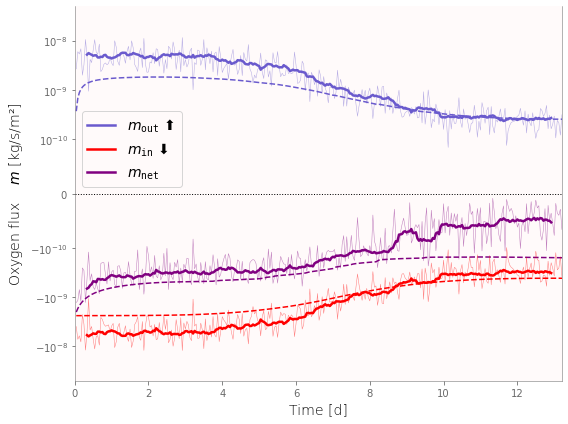

In [10]:
fields = ["O2"]
fig,axs = plt.subplots(len(fields),1,sharex=True,figsize=[8,6])

df = RANS
for ax,field in zip([axs],fields):
    ax.plot(df['Time (d)'],df[f'massIn {field} (kg/s/m2)'],
        c='red',alpha=1,lw=1.5,ls='dashed')
    ax.plot(df['Time (d)'],df[f'massOut {field} (kg/s/m2)'],
        c='slateblue',alpha=1,lw=1.5,ls='dashed')
    ax.plot(df['Time (d)'],df[f'massNet {field} (kg/s/m2)'],
        c='purple',alpha=1,lw=1.5,ls='dashed')

df = LES
for ax,field in zip([axs],fields):
    ax.plot(df['Time (d)'],df[f'massIn {field} (kg/s/m2)'],
        c='red',alpha=0.5,lw=0.5)
    ax.plot(df['Time (d)'],df[f'massOut {field} (kg/s/m2)'],
        c='slateblue',alpha=0.5,lw=0.5)
    ax.plot(df['Time (d)'],df[f'massNet {field} (kg/s/m2)'],
        c='purple',alpha=0.5,lw=0.5)
    ax.axhline(y=0,ls=':',lw=1,c='k')
    ax.set_xlim([0,13.2])

    LES[f'Rolling_massOut_{field}'] = LES[f'massOut {field} (kg/s/m2)'].rolling(15,center=True).mean()
    ax.plot(LES['Time (d)'],LES[f'Rolling_massOut_{field}'],
            c='slateblue',alpha=1,lw=2.5,label=r'$m_\mathtt{out}$ ⬆️')

    LES[f'Rolling_massIn_{field}'] = LES[f'massIn {field} (kg/s/m2)'].rolling(15,center=True).mean()
    ax.plot(LES['Time (d)'],LES[f'Rolling_massIn_{field}'],
             c='red',alpha=1,lw=2.5,label=r'$m_\mathtt{in}$ ⬇️')

    LES[f'Rolling_massNet_{field}'] = LES[f'massNet {field} (kg/s/m2)'].rolling(15,center=True).mean()
    ax.plot(LES['Time (d)'],LES[f'Rolling_massNet_{field}'],
            c='purple',alpha=1,lw=2.5,label=r'$m_\mathtt{net}$')

ax = axs
ax.set(ylim=[-5.0E-8,5.0E-8])
ax.set_yscale('symlog', linthresh=1E-10)

ax.legend(loc='lower left',bbox_to_anchor=(0.0,0.5))

ax.set_xlabel("Time [d]")
ax.set_ylabel(r"Oxygen flux    $m$ [kg/s/m²]")

fig.tight_layout()

fileForSVG = f"RetrieveFluxes/{isHot=}_ChemsFlux.svg"
plt.savefig(fileForSVG)
# os.system(f"xclip -se c -t image/png -i {fileForSVG}")
plt.show()


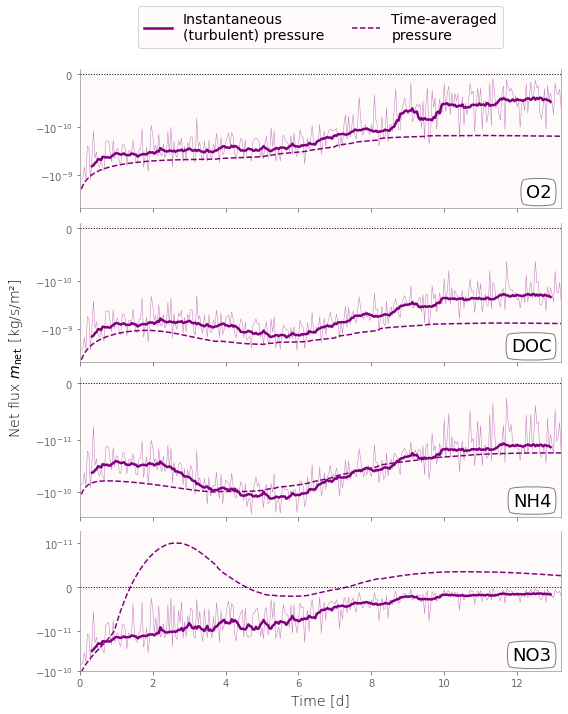

In [11]:
fields = ["O2","DOC","NH4","NO3"]
fig,axs = plt.subplots(len(fields),1,sharex=True,figsize=[8,10])

for ax,field in zip(axs,fields):
    ax.plot(LES['Time (d)'],LES[f'massNet {field} (kg/s/m2)'],
            c='purple',alpha=0.5,lw=0.5)

    LES[f'Rolling_massNet_{field}'] = LES[f'massNet {field} (kg/s/m2)'].rolling(15,center=True).mean()
    ax.plot(LES['Time (d)'],LES[f'Rolling_massNet_{field}'],
            c='purple',alpha=1,lw=2.5,label='Instantaneous\n(turbulent) pressure')

    ax.plot(RANS['Time (d)'],RANS[f'massNet {field} (kg/s/m2)'],
            c='purple',lw=1.5,ls='dashed',label='Time-averaged\npressure')
    ax.axhline(y=0,ls=':',lw=1,c='k')
    ax.annotate(f"{field}", fontsize=18,
                xy=(0.98, 0.05), xycoords='axes fraction',
                xytext=(0.98, 0.05), textcoords='axes fraction',
                ha='right',va='bottom',
                bbox=dict(boxstyle="round4", fc="w", ec="gray"))

ax.set_xlabel(r"Time [d]")
ax.set_xlim((0,13.2))
fig.supylabel(r"Net flux $m_\mathtt{net}$ [kg/s/m²]",fontsize=14)

axs[0].legend(loc='lower center',bbox_to_anchor=(0.5,1.1),ncol=2)

axs[0].set_yscale('symlog', linthresh=1.0E-10)
axs[0].set_ylim([-5.0E-9,1.0E-11])

axs[1].set_yscale('symlog', linthresh=1.0E-10)
axs[1].set_ylim([-5.0E-9,1.0E-11])

axs[2].set_yscale('symlog', linthresh=1.0E-11)
axs[2].set_ylim([-3.0E-10,1.0E-12])

axs[3].set_yscale('symlog', linthresh=1.0E-11)
axs[3].set_ylim([-1.0E-10,2.0E-11])

fig.tight_layout()

fileForSVG = f"RetrieveFluxes/{isHot=}_ChemsNet.svg"
plt.savefig(fileForSVG)
# os.system(f"xclip -se c -t image/png -i {fileForSVG}")
plt.show()